In [20]:
# Import libraries yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Baca dataset dari sheet 2 dan 3
file_path = 'Dataset/Dataset Keuangan Truk Air Isi Ulang 2024.xlsx'

# Baca semua sheet untuk melihat nama sheet yang tersedia
excel_file = pd.ExcelFile(file_path)
print("Sheet yang tersedia:", excel_file.sheet_names)

# Baca sheet 2 dan 3
df_sheet2 = pd.read_excel(file_path, sheet_name=excel_file.sheet_names[1])
df_sheet3 = pd.read_excel(file_path, sheet_name=excel_file.sheet_names[2])

print(f"\n=== SHEET 2 ({excel_file.sheet_names[1]}) ===")
print(f"Ukuran dataset: {df_sheet2.shape}")
print(f"Kolom: {list(df_sheet2.columns)}")
print("\nSample data:")
print(df_sheet2.head())

print(f"\n=== SHEET 3 ({excel_file.sheet_names[2]}) ===")
print(f"Ukuran dataset: {df_sheet3.shape}")
print(f"Kolom: {list(df_sheet3.columns)}")
print("\nSample data:")
print(df_sheet3.head())

Sheet yang tersedia: ['deskripsi', 'Dataset Keuangan Truk Air Isi U', 'lokasi']

=== SHEET 2 (Dataset Keuangan Truk Air Isi U) ===
Ukuran dataset: (1105, 11)
Kolom: ['No', 'Tanggal', 'Sopir', 'Plat Nomor', 'Order', 'Volume (L)', 'Pemasukan', 'Pengeluaran', 'Jenis Transaksi', 'Jumlah', 'Keterangan']

Sample data:
   No    Tanggal       Sopir Plat Nomor                  Order Volume (L)  \
0   1 2024-06-01    Pak Joko  H 1111 AA        Depot Air Sehat       6000   
1   2 2024-06-01    Pak Dedi  H 2222 BB        Depot Air Sehat       8000   
2   3 2024-06-01    Pak Rudi  H 2222 BB  Warung Lesehan Berkah      10000   
3   4 2024-06-01  Pak Slamet  H 1234 CD              Ganti Oli          -   
4   5 2024-06-02  Pak Slamet  H 2222 BB  Warung Lesehan Berkah      10000   

   Pemasukan  Pengeluaran Jenis Transaksi  Jumlah        Keterangan  
0     366245            0       Pemasukan  366245  Pembayaran lunas  
1     360609            0       Pemasukan  360609  Pembayaran lunas  
2     367988 

In [21]:
# Analisis nilai NULL dan UNKNOWN untuk kedua sheet
def analyze_missing_values(df, sheet_name):
    print(f"\n=== ANALISIS MISSING VALUES - {sheet_name} ===")
    
    # Identifikasi nilai NULL, NaN, dan UNKNOWN
    missing_info = {}
    
    for col in df.columns:
        null_count = df[col].isnull().sum()
        unknown_count = df[col].astype(str).str.upper().isin(['UNKNOWN', 'NULL', 'NAN', '', ' ']).sum()
        total_missing = null_count + unknown_count
        missing_percentage = (total_missing / len(df)) * 100
        
        missing_info[col] = {
            'null_count': null_count,
            'unknown_count': unknown_count,
            'total_missing': total_missing,
            'percentage': missing_percentage
        }
        
        if total_missing > 0:
            print(f"{col}: {total_missing} missing ({missing_percentage:.2f}%)")
            print(f"  - NULL/NaN: {null_count}")
            print(f"  - UNKNOWN/empty: {unknown_count}")
    
    return missing_info

# Analisis untuk kedua sheet
missing_sheet2 = analyze_missing_values(df_sheet2, "SHEET 2")
missing_sheet3 = analyze_missing_values(df_sheet3, "SHEET 3")


=== ANALISIS MISSING VALUES - SHEET 2 ===
Tanggal: 5 missing (0.45%)
  - NULL/NaN: 5
  - UNKNOWN/empty: 0
Sopir: 10 missing (0.90%)
  - NULL/NaN: 5
  - UNKNOWN/empty: 5
Plat Nomor: 22 missing (1.99%)
  - NULL/NaN: 11
  - UNKNOWN/empty: 11
Order: 4 missing (0.36%)
  - NULL/NaN: 2
  - UNKNOWN/empty: 2

=== ANALISIS MISSING VALUES - SHEET 3 ===
Unnamed: 0: 16 missing (200.00%)
  - NULL/NaN: 8
  - UNKNOWN/empty: 8


In [22]:
# Fungsi untuk membersihkan dan standarisasi nilai UNKNOWN
def clean_unknown_values(df):
    df_clean = df.copy()
    
    # Daftar nilai yang dianggap sebagai missing/unknown
    unknown_values = ['UNKNOWN', 'NULL', 'NAN', '', ' ', 'N/A', 'NA', '-']
    
    for col in df_clean.columns:
        # Replace nilai unknown dengan NaN
        df_clean[col] = df_clean[col].replace(unknown_values, np.nan)
        
        # Untuk kolom string, handle case sensitivity
        if df_clean[col].dtype == 'object':
            mask = df_clean[col].astype(str).str.upper().isin([v.upper() for v in unknown_values])
            df_clean.loc[mask, col] = np.nan
    
    return df_clean

# Bersihkan kedua dataset
df_sheet2_clean = clean_unknown_values(df_sheet2)
df_sheet3_clean = clean_unknown_values(df_sheet3)

print("Dataset setelah pembersihan:")
print(f"Sheet 2 - Missing values: {df_sheet2_clean.isnull().sum().sum()}")
print(f"Sheet 3 - Missing values: {df_sheet3_clean.isnull().sum().sum()}")

Dataset setelah pembersihan:
Sheet 2 - Missing values: 325
Sheet 3 - Missing values: 8


In [23]:
# Fungsi untuk menghapus kolom unnamed khususnya di kolom 1 sheet 3
def remove_unnamed_columns(df, sheet_name):
    df_clean = df.copy()
    print(f"\n=== MEMBERSIHKAN KOLOM UNNAMED - {sheet_name} ===")
    print(f"Kolom sebelum pembersihan: {list(df_clean.columns)}")
    
    # Hapus kolom yang unnamed (biasanya dimulai dengan 'Unnamed:')
    unnamed_cols = [col for col in df_clean.columns if 'Unnamed:' in str(col)]
    
    if unnamed_cols:
        print(f"Menghapus kolom unnamed: {unnamed_cols}")
        df_clean = df_clean.drop(columns=unnamed_cols)
    
    # Hapus kolom kosong di posisi pertama jika ada
    if len(df_clean.columns) > 0:
        first_col = df_clean.columns[0]
        if df_clean[first_col].isnull().all() or str(first_col).startswith('Unnamed'):
            print(f"Menghapus kolom pertama yang kosong/unnamed: {first_col}")
            df_clean = df_clean.drop(columns=[first_col])
    
    # Hapus kolom yang semua nilainya NaN
    empty_cols = df_clean.columns[df_clean.isnull().all()].tolist()
    if empty_cols:
        print(f"Menghapus kolom kosong: {empty_cols}")
        df_clean = df_clean.drop(columns=empty_cols)
    
    print(f"Kolom setelah pembersihan: {list(df_clean.columns)}")
    print(f"Ukuran dataset: {df_clean.shape}")
    
    return df_clean

# Bersihkan kolom unnamed untuk kedua sheet
df_sheet2_clean = remove_unnamed_columns(df_sheet2_clean, "SHEET 2")
df_sheet3_clean = remove_unnamed_columns(df_sheet3_clean, "SHEET 3")

# Update variabel untuk digunakan di cell selanjutnya
df_sheet2 = df_sheet2_clean
df_sheet3 = df_sheet3_clean

print("\n=== RINGKASAN SETELAH PEMBERSIHAN ===")
print(f"Sheet 2: {df_sheet2.shape}")
print(f"Sheet 3: {df_sheet3.shape}")
print(f"Sheet 2 - Missing values: {df_sheet2.isnull().sum().sum()}")
print(f"Sheet 3 - Missing values: {df_sheet3.isnull().sum().sum()}")


=== MEMBERSIHKAN KOLOM UNNAMED - SHEET 2 ===
Kolom sebelum pembersihan: ['No', 'Tanggal', 'Sopir', 'Plat Nomor', 'Order', 'Volume (L)', 'Pemasukan', 'Pengeluaran', 'Jenis Transaksi', 'Jumlah', 'Keterangan']
Kolom setelah pembersihan: ['No', 'Tanggal', 'Sopir', 'Plat Nomor', 'Order', 'Volume (L)', 'Pemasukan', 'Pengeluaran', 'Jenis Transaksi', 'Jumlah', 'Keterangan']
Ukuran dataset: (1105, 11)

=== MEMBERSIHKAN KOLOM UNNAMED - SHEET 3 ===
Kolom sebelum pembersihan: ['Unnamed: 0', 'Nama Lokasi', 'Latitude', 'Longitude']
Menghapus kolom unnamed: ['Unnamed: 0']
Kolom setelah pembersihan: ['Nama Lokasi', 'Latitude', 'Longitude']
Ukuran dataset: (8, 3)

=== RINGKASAN SETELAH PEMBERSIHAN ===
Sheet 2: (1105, 11)
Sheet 3: (8, 3)
Sheet 2 - Missing values: 325
Sheet 3 - Missing values: 0


In [24]:
# Fungsi untuk imputasi berdasarkan similarity dan mode
def smart_imputation(df, method='similarity'):
    df_imputed = df.copy()
    
    # Pisahkan kolom numerik dan kategorikal
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Kolom numerik: {numeric_cols}")
    print(f"Kolom kategorikal: {categorical_cols}")
    
    # Imputasi untuk kolom kategorikal (gunakan mode/nilai terbanyak)
    for col in categorical_cols:
        if df_imputed[col].isnull().any():
            mode_value = df_imputed[col].mode()
            if len(mode_value) > 0:
                df_imputed[col].fillna(mode_value[0], inplace=True)
                print(f"Kolom '{col}' diisi dengan mode: '{mode_value[0]}'")
    
    # Imputasi untuk kolom numerik
    if method == 'similarity' and len(numeric_cols) > 0:
        # Gunakan KNN Imputer untuk similarity-based imputation
        imputer = KNNImputer(n_neighbors=5)
        df_imputed[numeric_cols] = imputer.fit_transform(df_imputed[numeric_cols])
        print("Kolom numerik diimputasi menggunakan KNN (similarity-based)")
    
    elif method == 'mean' and len(numeric_cols) > 0:
        # Gunakan mean untuk imputasi sederhana
        for col in numeric_cols:
            if df_imputed[col].isnull().any():
                mean_value = df_imputed[col].mean()
                df_imputed[col].fillna(mean_value, inplace=True)
                print(f"Kolom '{col}' diisi dengan mean: {mean_value:.2f}")
    
    return df_imputed

# Lakukan imputasi untuk kedua dataset
print("=== IMPUTASI SHEET 2 ===")
df_sheet2_imputed = smart_imputation(df_sheet2_clean, method='similarity')

print("\n=== IMPUTASI SHEET 3 ===")
df_sheet3_imputed = smart_imputation(df_sheet3_clean, method='similarity')

=== IMPUTASI SHEET 2 ===
Kolom numerik: ['No', 'Volume (L)', 'Pemasukan', 'Pengeluaran', 'Jumlah']
Kolom kategorikal: ['Sopir', 'Plat Nomor', 'Order', 'Jenis Transaksi', 'Keterangan']
Kolom 'Sopir' diisi dengan mode: 'Pak Joko'
Kolom 'Plat Nomor' diisi dengan mode: 'H 1234 CD'
Kolom 'Order' diisi dengan mode: 'Toko Maju Jaya'
Kolom numerik diimputasi menggunakan KNN (similarity-based)

=== IMPUTASI SHEET 3 ===
Kolom numerik: ['Latitude', 'Longitude']
Kolom kategorikal: ['Nama Lokasi']
Kolom numerik diimputasi menggunakan KNN (similarity-based)


In [25]:
# Validasi hasil imputasi
def validate_imputation(df_original, df_imputed, sheet_name):
    print(f"\n=== VALIDASI HASIL IMPUTASI - {sheet_name} ===")
    
    print(f"Missing values sebelum imputasi: {df_original.isnull().sum().sum()}")
    print(f"Missing values setelah imputasi: {df_imputed.isnull().sum().sum()}")
    
    # Tampilkan perbandingan per kolom
    for col in df_original.columns:
        before = df_original[col].isnull().sum()
        after = df_imputed[col].isnull().sum()
        if before > 0:
            print(f"Kolom '{col}': {before} → {after} missing values")
    
    # Tampilkan statistik deskriptif untuk kolom numerik
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nStatistik deskriptif kolom numerik:")
        print(df_imputed[numeric_cols].describe())

# Validasi kedua dataset
validate_imputation(df_sheet2_clean, df_sheet2_imputed, "SHEET 2")
validate_imputation(df_sheet3_clean, df_sheet3_imputed, "SHEET 3")


=== VALIDASI HASIL IMPUTASI - SHEET 2 ===
Missing values sebelum imputasi: 325
Missing values setelah imputasi: 5
Kolom 'Tanggal': 5 → 5 missing values
Kolom 'Sopir': 5 → 0 missing values
Kolom 'Plat Nomor': 11 → 0 missing values
Kolom 'Order': 2 → 0 missing values
Kolom 'Volume (L)': 302 → 0 missing values

Statistik deskriptif kolom numerik:
                No    Volume (L)      Pemasukan    Pengeluaran         Jumlah
count  1105.000000   1105.000000    1105.000000    1105.000000    1105.000000
mean    553.000000   8152.760181  250075.541176   40994.006335  209081.534842
std     319.130329   1369.483030  156099.341327   73596.480419  224288.240144
min       1.000000   6000.000000       0.000000       0.000000 -249785.000000
25%     277.000000   8000.000000       0.000000       0.000000  -64662.000000
50%     553.000000   8400.000000  322579.000000       0.000000  322579.000000
75%     829.000000   8400.000000  363959.000000   64662.000000  363959.000000
max    1105.000000  10000.000

In [26]:
# Fungsi khusus untuk menangani missing values pada kolom tanggal di Sheet 2
def handle_date_missing_values_sheet2(df):
    df_clean = df.copy()
    print(f"\n=== MENANGANI MISSING VALUES TANGGAL - SHEET 2 ===")
    
    # Identifikasi kolom yang mungkin berisi tanggal
    date_columns = []
    for col in df_clean.columns:
        col_name = str(col).lower()
        if any(keyword in col_name for keyword in ['tanggal', 'date', 'tgl', 'waktu', 'time']):
            date_columns.append(col)
    
    print(f"Kolom tanggal yang terdeteksi: {date_columns}")
    
    for col in date_columns:
        print(f"\nMemproses kolom tanggal: {col}")
        
        # Tampilkan sample data sebelum konversi
        print(f"Sample data sebelum konversi:")
        print(df_clean[col].head(10))
        
        # Konversi ke datetime jika belum
        try:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
            print(f"Berhasil konversi ke datetime")
        except Exception as e:
            print(f"Gagal konversi kolom {col} ke datetime: {e}")
            continue
        
        # Hitung missing values
        missing_count = df_clean[col].isnull().sum()
        print(f"Missing values: {missing_count}")
        
        if missing_count > 0:
            # Method 1: Forward fill (menggunakan tanggal sebelumnya)
            before_ffill = df_clean[col].isnull().sum()
            df_clean[col] = df_clean[col].fillna(method='ffill')
            after_ffill = df_clean[col].isnull().sum()
            print(f"Setelah forward fill: {before_ffill} → {after_ffill}")
            
            # Method 2: Jika masih ada missing di awal, gunakan backward fill
            if df_clean[col].isnull().sum() > 0:
                before_bfill = df_clean[col].isnull().sum()
                df_clean[col] = df_clean[col].fillna(method='bfill')
                after_bfill = df_clean[col].isnull().sum()
                print(f"Setelah backward fill: {before_bfill} → {after_bfill}")
            
            # Method 3: Jika masih ada missing, gunakan median date
            if df_clean[col].isnull().sum() > 0:
                median_date = df_clean[col].median()
                df_clean[col] = df_clean[col].fillna(median_date)
                print(f"Menggunakan median date: {median_date}")
            
            print(f"Missing values setelah imputasi: {df_clean[col].isnull().sum()}")
        
        # Tampilkan info tanggal
        if not df_clean[col].isnull().all():
            print(f"Rentang tanggal: {df_clean[col].min()} sampai {df_clean[col].max()}")
            print(f"Total hari: {(df_clean[col].max() - df_clean[col].min()).days} hari")
    
    return df_clean

# Terapkan preprocessing tanggal hanya untuk Sheet 2
df_sheet2_date_clean = handle_date_missing_values_sheet2(df_sheet2_imputed)

# Sheet 3 tidak perlu preprocessing tanggal, gunakan hasil imputasi sebelumnya
df_sheet3_final = df_sheet3_imputed.copy()

# Update dataset final
df_sheet2_final = df_sheet2_date_clean

print("\n=== RINGKASAN AKHIR PREPROCESSING ===")
print(f"Sheet 2 - Total missing values: {df_sheet2_final.isnull().sum().sum()}")
print(f"Sheet 3 - Total missing values: {df_sheet3_final.isnull().sum().sum()}")

# Tampilkan detail missing values per kolom jika masih ada
for df, name in [(df_sheet2_final, "Sheet 2"), (df_sheet3_final, "Sheet 3")]:
    missing_cols = df.columns[df.isnull().any()].tolist()
    if missing_cols:
        print(f"\n{name} - Kolom yang masih memiliki missing values:")
        for col in missing_cols:
            print(f"  {col}: {df[col].isnull().sum()} missing")
    else:
        print(f"\n{name} - Tidak ada missing values tersisa")


=== MENANGANI MISSING VALUES TANGGAL - SHEET 2 ===
Kolom tanggal yang terdeteksi: ['Tanggal']

Memproses kolom tanggal: Tanggal
Sample data sebelum konversi:
0   2024-06-01
1   2024-06-01
2   2024-06-01
3   2024-06-01
4   2024-06-02
5   2024-06-02
6   2024-06-02
7   2024-06-03
8   2024-06-03
9   2024-06-03
Name: Tanggal, dtype: datetime64[ns]
Berhasil konversi ke datetime
Missing values: 5
Setelah forward fill: 5 → 0
Missing values setelah imputasi: 0
Rentang tanggal: 2024-01-01 00:00:00 sampai 2024-12-31 00:00:00
Total hari: 365 hari

=== RINGKASAN AKHIR PREPROCESSING ===
Sheet 2 - Total missing values: 0
Sheet 3 - Total missing values: 0

Sheet 2 - Tidak ada missing values tersisa

Sheet 3 - Tidak ada missing values tersisa


=== VISUALISASI HASIL PREPROCESSING ===


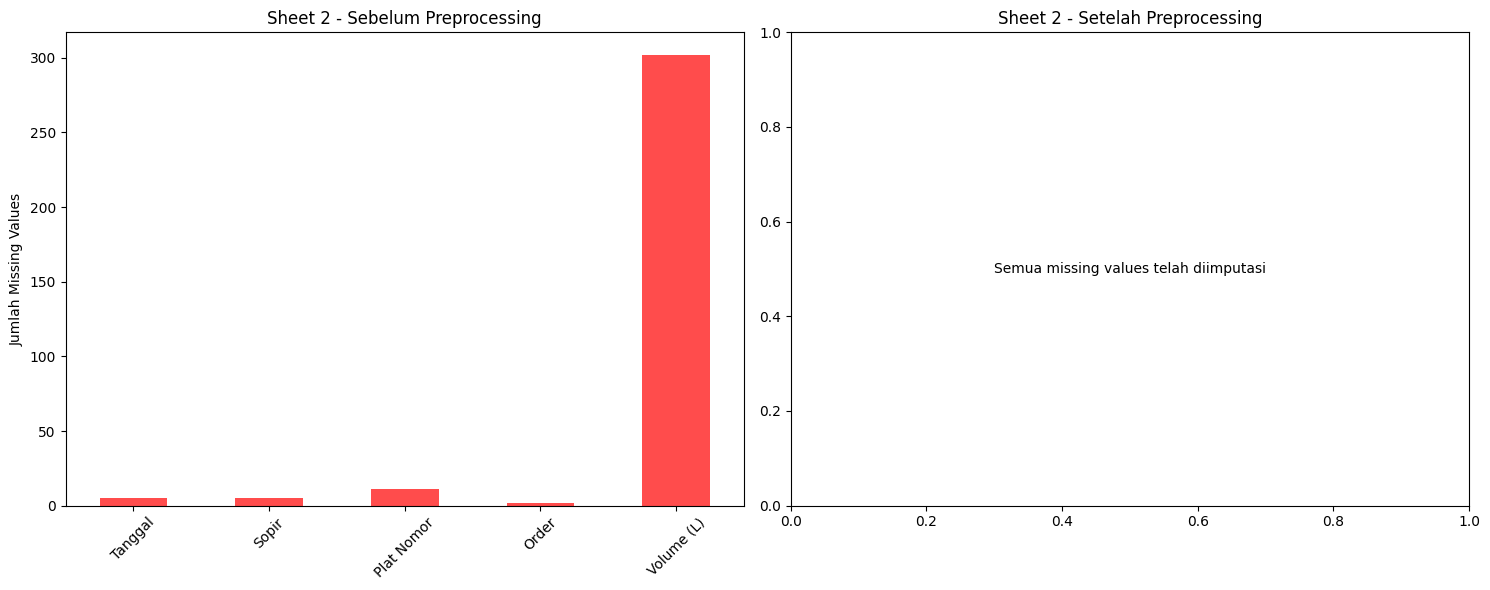

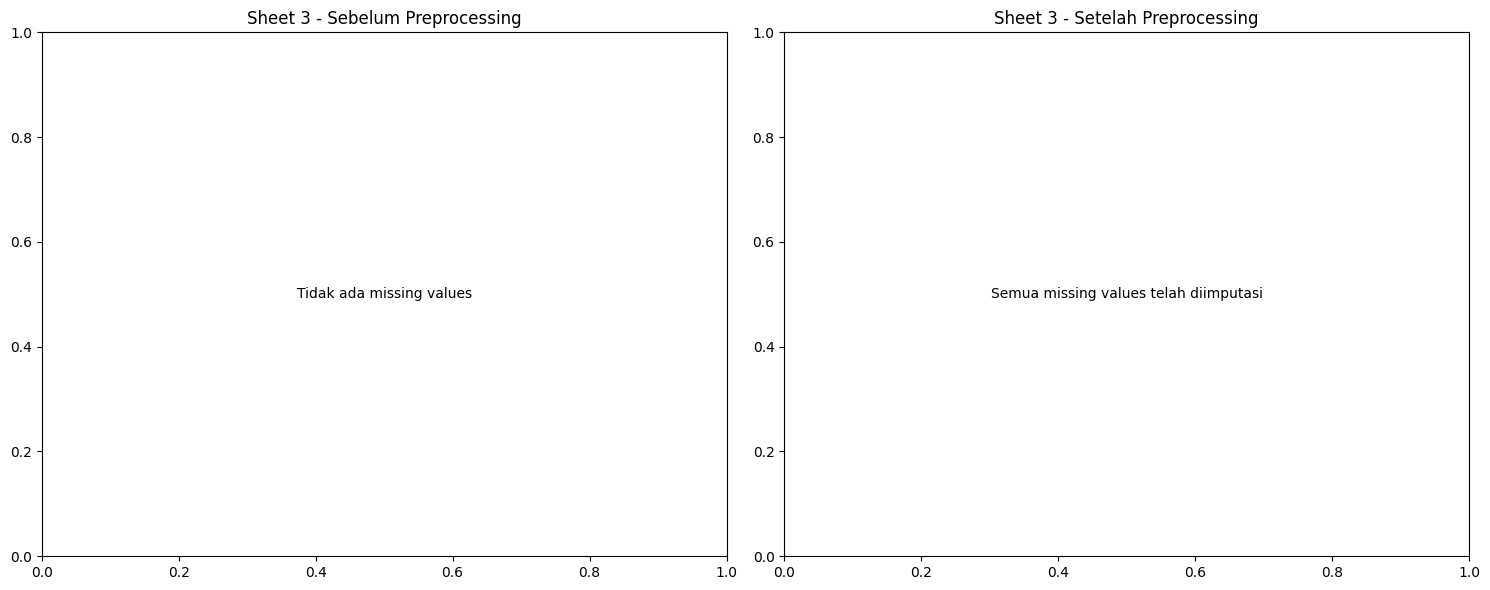


=== MENYIMPAN HASIL PREPROCESSING FINAL ===
Dataset final yang sudah dipreprocessing disimpan ke 'Dataset/Dataset_Preprocessed_Final.xlsx'

=== SAMPLE DATA FINAL ===
Sheet 2 (5 baris pertama):
    No    Tanggal       Sopir Plat Nomor                  Order  Volume (L)  \
0  1.0 2024-06-01    Pak Joko  H 1111 AA        Depot Air Sehat      6000.0   
1  2.0 2024-06-01    Pak Dedi  H 2222 BB        Depot Air Sehat      8000.0   
2  3.0 2024-06-01    Pak Rudi  H 2222 BB  Warung Lesehan Berkah     10000.0   
3  4.0 2024-06-01  Pak Slamet  H 1234 CD              Ganti Oli      8400.0   
4  5.0 2024-06-02  Pak Slamet  H 2222 BB  Warung Lesehan Berkah     10000.0   

   Pemasukan  Pengeluaran Jenis Transaksi    Jumlah        Keterangan  
0   366245.0          0.0       Pemasukan  366245.0  Pembayaran lunas  
1   360609.0          0.0       Pemasukan  360609.0  Pembayaran lunas  
2   367988.0          0.0       Pemasukan  367988.0  Pembayaran lunas  
3        0.0     111296.0     Pengeluaran -

In [28]:
# Visualisasi missing values dan penyimpanan hasil final
def plot_final_missing_values(df_original, df_final, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Missing values sebelum preprocessing
    missing_before = df_original.isnull().sum()
    missing_before = missing_before[missing_before > 0]
    
    if len(missing_before) > 0:
        missing_before.plot(kind='bar', ax=ax1, color='red', alpha=0.7)
        ax1.set_title(f'{title} - Sebelum Preprocessing')
        ax1.set_ylabel('Jumlah Missing Values')
        ax1.tick_params(axis='x', rotation=45)
    else:
        ax1.text(0.5, 0.5, 'Tidak ada missing values', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title(f'{title} - Sebelum Preprocessing')
    
    # Missing values setelah preprocessing
    missing_after = df_final.isnull().sum()
    missing_after = missing_after[missing_after > 0]
    
    if len(missing_after) > 0:
        missing_after.plot(kind='bar', ax=ax2, color='green', alpha=0.7)
        ax2.set_title(f'{title} - Setelah Preprocessing')
        ax2.set_ylabel('Jumlah Missing Values')
        ax2.tick_params(axis='x', rotation=45)
    else:
        ax2.text(0.5, 0.5, 'Semua missing values telah diimputasi', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title(f'{title} - Setelah Preprocessing')
    
    plt.tight_layout()
    plt.show()

# Plot untuk kedua sheet
print("=== VISUALISASI HASIL PREPROCESSING ===")
plot_final_missing_values(df_sheet2, df_sheet2_final, "Sheet 2")
plot_final_missing_values(df_sheet3, df_sheet3_final, "Sheet 3")

# Simpan hasil preprocessing final
print("\n=== MENYIMPAN HASIL PREPROCESSING FINAL ===")

with pd.ExcelWriter('Dataset/Dataset_Preprocessed_Final.xlsx') as writer:
    df_sheet2_final.to_excel(writer, sheet_name='Sheet2_Final', index=False)
    df_sheet3_final.to_excel(writer, sheet_name='Sheet3_Final', index=False)

print("Dataset final yang sudah dipreprocessing disimpan ke 'Dataset/Dataset_Preprocessed_Final.xlsx'")

# Tampilkan sample data final
print(f"\n=== SAMPLE DATA FINAL ===")
print("Sheet 2 (5 baris pertama):")
print(df_sheet2_final.head())
print("\nSheet 3 (5 baris pertama):")
print(df_sheet3_final.head())

# Tampilkan info dataset final
print(f"\n=== INFO DATASET FINAL ===")
print(f"Sheet 2: {df_sheet2_final.shape}")
print(f"Sheet 3: {df_sheet3_final.shape}")
print(f"Total kolom Sheet 2: {len(df_sheet2_final.columns)}")
print(f"Total kolom Sheet 3: {len(df_sheet3_final.columns)}")

# Tampilkan ringkasan kolom tanggal di Sheet 2
date_cols = [col for col in df_sheet2_final.columns if 'tanggal' in str(col).lower()]
if date_cols:
    print(f"\n=== RINGKASAN KOLOM TANGGAL SHEET 2 ===")
    for col in date_cols:
        print(f"Kolom: {col}")
        print(f"  - Type: {df_sheet2_final[col].dtype}")
        print(f"  - Missing values: {df_sheet2_final[col].isnull().sum()}")
        if not df_sheet2_final[col].isnull().all():
            print(f"  - Min: {df_sheet2_final[col].min()}")
            print(f"  - Max: {df_sheet2_final[col].max()}")

In [29]:
# Pengecekan menyeluruh missing values untuk Sheet 2 dan Sheet 3
def comprehensive_missing_check(df, sheet_name):
    print(f"\n{'='*50}")
    print(f"PENGECEKAN MISSING VALUES - {sheet_name}")
    print(f"{'='*50}")
    
    # Info dasar dataset
    print(f"Ukuran dataset: {df.shape}")
    print(f"Total data points: {df.shape[0] * df.shape[1]}")
    print(f"Total missing values: {df.isnull().sum().sum()}")
    print(f"Persentase missing: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")
    
    # Missing values per kolom
    missing_per_col = df.isnull().sum()
    missing_percentage_per_col = (missing_per_col / len(df)) * 100
    
    print(f"\n--- MISSING VALUES PER KOLOM ---")
    for col in df.columns:
        missing_count = missing_per_col[col]
        missing_pct = missing_percentage_per_col[col]
        status = "✅ BERSIH" if missing_count == 0 else f"❌ {missing_count} missing ({missing_pct:.2f}%)"
        print(f"{col}: {status}")
    
    # Statistik missing values
    if missing_per_col.sum() > 0:
        print(f"\n--- STATISTIK MISSING VALUES ---")
        print(f"Kolom dengan missing terbanyak: {missing_per_col.idxmax()} ({missing_per_col.max()} missing)")
        print(f"Jumlah kolom yang memiliki missing: {(missing_per_col > 0).sum()}")
        print(f"Jumlah kolom yang bersih: {(missing_per_col == 0).sum()}")
        
        # Baris dengan missing values
        rows_with_missing = df.isnull().any(axis=1).sum()
        print(f"Baris yang memiliki missing values: {rows_with_missing} dari {len(df)} baris")
        print(f"Persentase baris dengan missing: {(rows_with_missing / len(df)) * 100:.2f}%")
    else:
        print(f"\n🎉 SELAMAT! Dataset {sheet_name} sudah bersih dari missing values!")
    
    return {
        'total_missing': missing_per_col.sum(),
        'missing_per_column': missing_per_col.to_dict(),
        'missing_percentage_per_column': missing_percentage_per_col.to_dict(),
        'rows_with_missing': df.isnull().any(axis=1).sum() if missing_per_col.sum() > 0 else 0
    }

# Cek missing values untuk kedua dataset
print("PENGECEKAN COMPREHENSIVE MISSING VALUES")
print("="*60)

# Cek Sheet 2
sheet2_missing_info = comprehensive_missing_check(df_sheet2_final, "SHEET 2")

# Cek Sheet 3  
sheet3_missing_info = comprehensive_missing_check(df_sheet3_final, "SHEET 3")

# Ringkasan keseluruhan
print(f"\n{'='*60}")
print("RINGKASAN KESELURUHAN")
print(f"{'='*60}")
print(f"Sheet 2 - Total missing: {sheet2_missing_info['total_missing']}")
print(f"Sheet 3 - Total missing: {sheet3_missing_info['total_missing']}")
print(f"Total missing kedua sheet: {sheet2_missing_info['total_missing'] + sheet3_missing_info['total_missing']}")

if sheet2_missing_info['total_missing'] == 0 and sheet3_missing_info['total_missing'] == 0:
    print("\n🎉 SEMPURNA! Kedua dataset sudah bersih dari missing values!")
else:
    print(f"\n⚠️  Masih ada {sheet2_missing_info['total_missing'] + sheet3_missing_info['total_missing']} missing values yang perlu ditangani")

PENGECEKAN COMPREHENSIVE MISSING VALUES

PENGECEKAN MISSING VALUES - SHEET 2
Ukuran dataset: (1105, 11)
Total data points: 12155
Total missing values: 0
Persentase missing: 0.00%

--- MISSING VALUES PER KOLOM ---
No: ✅ BERSIH
Tanggal: ✅ BERSIH
Sopir: ✅ BERSIH
Plat Nomor: ✅ BERSIH
Order: ✅ BERSIH
Volume (L): ✅ BERSIH
Pemasukan: ✅ BERSIH
Pengeluaran: ✅ BERSIH
Jenis Transaksi: ✅ BERSIH
Jumlah: ✅ BERSIH
Keterangan: ✅ BERSIH

🎉 SELAMAT! Dataset SHEET 2 sudah bersih dari missing values!

PENGECEKAN MISSING VALUES - SHEET 3
Ukuran dataset: (8, 3)
Total data points: 24
Total missing values: 0
Persentase missing: 0.00%

--- MISSING VALUES PER KOLOM ---
Nama Lokasi: ✅ BERSIH
Latitude: ✅ BERSIH
Longitude: ✅ BERSIH

🎉 SELAMAT! Dataset SHEET 3 sudah bersih dari missing values!

RINGKASAN KESELURUHAN
Sheet 2 - Total missing: 0
Sheet 3 - Total missing: 0
Total missing kedua sheet: 0

🎉 SEMPURNA! Kedua dataset sudah bersih dari missing values!


In [30]:
# Simpan dataset setelah cleaning
import os

print("="*60)
print("MENYIMPAN DATASET SETELAH CLEANING")
print("="*60)

# Buat folder untuk menyimpan hasil jika belum ada
if not os.path.exists('Dataset/Cleaned'):
    os.makedirs('Dataset/Cleaned')
    print("Folder 'Dataset/Cleaned' telah dibuat")

# 1. Simpan ke Excel dengan multiple sheets
excel_file = 'Dataset/Cleaned/Dataset_Cleaned_Final.xlsx'
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    df_sheet2_final.to_excel(writer, sheet_name='Sheet2_Cleaned', index=False)
    df_sheet3_final.to_excel(writer, sheet_name='Sheet3_Cleaned', index=False)

print(f"✅ Dataset Excel disimpan ke: {excel_file}")

# 2. Simpan ke CSV terpisah
csv_file_sheet2 = 'Dataset/Cleaned/Sheet2_Cleaned.csv'
csv_file_sheet3 = 'Dataset/Cleaned/Sheet3_Cleaned.csv'

df_sheet2_final.to_csv(csv_file_sheet2, index=False, encoding='utf-8')
df_sheet3_final.to_csv(csv_file_sheet3, index=False, encoding='utf-8')

print(f"✅ Sheet 2 CSV disimpan ke: {csv_file_sheet2}")
print(f"✅ Sheet 3 CSV disimpan ke: {csv_file_sheet3}")

# 3. Simpan ke Pickle untuk preservasi data types
pickle_file_sheet2 = 'Dataset/Cleaned/Sheet2_Cleaned.pkl'
pickle_file_sheet3 = 'Dataset/Cleaned/Sheet3_Cleaned.pkl'

df_sheet2_final.to_pickle(pickle_file_sheet2)
df_sheet3_final.to_pickle(pickle_file_sheet3)

print(f"✅ Sheet 2 Pickle disimpan ke: {pickle_file_sheet2}")
print(f"✅ Sheet 3 Pickle disimpan ke: {pickle_file_sheet3}")

# Tampilkan ringkasan
print(f"\n{'='*60}")
print("RINGKASAN FILE YANG TERSIMPAN")
print(f"{'='*60}")
print(f"📁 Total file tersimpan: 5 file")
print(f"📄 Excel: {excel_file}")
print(f"📄 CSV Sheet 2: {csv_file_sheet2}")
print(f"📄 CSV Sheet 3: {csv_file_sheet3}")
print(f"📄 Pickle Sheet 2: {pickle_file_sheet2}")
print(f"📄 Pickle Sheet 3: {pickle_file_sheet3}")

# Tampilkan ukuran file
print(f"\n📊 UKURAN FILE:")
files = [excel_file, csv_file_sheet2, csv_file_sheet3, pickle_file_sheet2, pickle_file_sheet3]
for file_path in files:
    if os.path.exists(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"   {os.path.basename(file_path)}: {size_mb:.2f} MB")

print(f"\n🎉 SEMUA DATA BERHASIL DISIMPAN!")
print("Dataset siap untuk digunakan pada tahap visualisasi selanjutnya.")

MENYIMPAN DATASET SETELAH CLEANING
Folder 'Dataset/Cleaned' telah dibuat
✅ Dataset Excel disimpan ke: Dataset/Cleaned/Dataset_Cleaned_Final.xlsx
✅ Sheet 2 CSV disimpan ke: Dataset/Cleaned/Sheet2_Cleaned.csv
✅ Sheet 3 CSV disimpan ke: Dataset/Cleaned/Sheet3_Cleaned.csv
✅ Sheet 2 Pickle disimpan ke: Dataset/Cleaned/Sheet2_Cleaned.pkl
✅ Sheet 3 Pickle disimpan ke: Dataset/Cleaned/Sheet3_Cleaned.pkl

RINGKASAN FILE YANG TERSIMPAN
📁 Total file tersimpan: 5 file
📄 Excel: Dataset/Cleaned/Dataset_Cleaned_Final.xlsx
📄 CSV Sheet 2: Dataset/Cleaned/Sheet2_Cleaned.csv
📄 CSV Sheet 3: Dataset/Cleaned/Sheet3_Cleaned.csv
📄 Pickle Sheet 2: Dataset/Cleaned/Sheet2_Cleaned.pkl
📄 Pickle Sheet 3: Dataset/Cleaned/Sheet3_Cleaned.pkl

📊 UKURAN FILE:
   Dataset_Cleaned_Final.xlsx: 0.06 MB
   Sheet2_Cleaned.csv: 0.12 MB
   Sheet3_Cleaned.csv: 0.00 MB
   Sheet2_Cleaned.pkl: 0.06 MB
   Sheet3_Cleaned.pkl: 0.00 MB

🎉 SEMUA DATA BERHASIL DISIMPAN!
Dataset siap untuk digunakan pada tahap visualisasi selanjutnya.
